# Exploratory Yelp Data Analysis and Visualization 

## Group: 

**Notes: this cell is reserved as a temperary Table of contents, please put any add-functionalities to this main notebook here**  
Table of contents  
Motivations  
Which cities to crawl (from two resources)  
Explain the Scrapy framework and functions  

## Table of Contents:
* [Project Overview and Motivations](#first-bullet)
   - [Part I: Data Loading and Pre-Processing](#sub1)
   - [Part II: Feature Selection & Engineering](#second-bullet)
    - [Section 2.1: Feature Selection Principle](#sub1)
      - [Features to be dropped](#sub2)
      - [Features to be re-engineered](#sub2)
      - [Features to be kept even there are missing, special imputation needed](#sub2)
    - [Section 2.2: Data Imputation](#sub1)
      - [Imputation using fillna to 0](#sub2)
      - [sklearn Imputation using the mean](#sub2)
    - [Section 2.3: Data Normalization](#sub1)
    - [Section 2.4: Data Spliting](#sub1)
   - [Part III: Classification Model Building](#third-bullet)
    - [Section 1: Selection of the Methodology](#sub1)
    - [Section 2: Method Implementation and Pipeline](#sub1)
   - [Part IV: Classification Model Optimization](#fourth-bullet)
   - [Part V: Extracting Feature Importance](#fifth-bullet)
   - [Part VI: Multi-class exploration](#fifth-bullet)
* [Comment on Future work](#future-work)

## Section 0: Project Overview and Motivations
The 

In [485]:
import pandas as pd
import sys
import numpy as np
# from pathlib import Path
from urllib.request import urlopen
import re
import string

import nltk
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings("ignore")

# Visualization pkgs
import matplotlib.pyplot as plt
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.style.use('ggplot')
import seaborn as sns
from plotnine import *
from wordcloud import WordCloud 
from pyecharts.charts import Pie
from pyecharts import options as opts

sys.path.insert(0, '/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages')
import pymysql
from bs4 import BeautifulSoup

In [2]:
# helper functions from Codebase 
sys.path.insert(0, '../Codebase/')
from db_utils import YelpDb
from MissingValue import MissingValue

## Section I: Build Web Crawler 
We used two resources to determine which cities in California  
Resource 1: https://patch.com/california/lajolla/ca-cities-rank-among-best-big-cities-live  
Resource 2: https://en.wikipedia.org/wiki/List_of_largest_California_cities_by_population

In [3]:
# Resource 1:
# open url connection 
link = 'https://patch.com/california/lajolla/ca-cities-rank-among-best-big-cities-live'
html = urlopen(link).read()
soup = BeautifulSoup(html, features="html5lib")

# use class to narrow search, based on observation 
target_level = soup.find('section', {"class": "article-body"})
target_level_2 = target_level.find_all('ol')[1]
target_level_3 = target_level_2.find_all('li')
cali_cities = []
for info in target_level_3:
    cali_cities.append(info.get_text(strip=True))
for i in cali_cities:
    flag = re.findall("[A-Za-z ]", i)
    if flag:
        token = "".join(flag)
        print(token)

San Diego 
San Francisco 
San Jose 
Sacramento 
Riverside 
Los Angeles 
Long Beach 
Anaheim 
Bakersfield 
Oakland 
Santa Ana 
Fresno 


In [4]:
# Resource 2:
link = 'https://en.wikipedia.org/wiki/List_of_largest_California_cities_by_population'
html = urlopen(link).read()

soup = BeautifulSoup(html, features="html")
cities = []
table = soup.find('table', {"class": "wikitable sortable"})
rows = table.find_all("tr")
for row in rows[1:]:
    city = row.find_all("td")[1].get_text(strip=True)
    cities.append(city)
print(cities[:12])

['Los Angeles', 'San Diego', 'San Jose', 'San Francisco', 'Fresno', 'Sacramento', 'Long Beach', 'Oakland', 'Bakersfield', 'Anaheim', 'Santa Ana', 'Riverside']


From the two resources, we 

## Section II: Read data from sql server into pandas

**Note**: this method is only for reading dumped .sql file that already live in local server; for usage of that .sql file on another machine, you need to refer this:  
https://blog.csdn.net/spartanfuk/article/details/81368465?depth_1-utm_source=distribute.pc_relevant.none-task

**Workflow**: 
1. .sql files to DF.
2. DFs to csv.
3. csv. to EDA
4. delete csv.


In [5]:
# playground


### Part I: Show all tables in two databases 

In [6]:
# build DB connections
yelp_db_group_1 = YelpDb("yelp_db_1_6")  # cities 1-6 (group 1)
yelp_db_group_2 = YelpDb("yelp_db")  # cities 7-12 (group 2)

sql_tabs = "show TABLES;"
yelp_db_group_1.execute(sql_tabs)
yelp_db_group_1.fetch_all()

(('yelp_fresno',),
 ('yelp_los_angeles',),
 ('yelp_sacramento',),
 ('yelp_san_diego',),
 ('yelp_san_francisco',),
 ('yelp_san_jose',))

In [7]:
yelp_db_group_2.execute(sql_tabs)
yelp_db_group_2.fetch_all()

(('yelp_Anaheim',),
 ('yelp_Bakersfield',),
 ('yelp_Long_Beach',),
 ('yelp_Oakland',),
 ('yelp_Riverside',),
 ('yelp_Santa_Ana',))

### Part II: Read databases into DataFrame 

In [8]:
# Table 1
yelp_df_la = yelp_db_group_1.db_to_df("yelp_los_angeles")
print(f'Yelp data for Los Angeles: number of rows (restaurants) = {yelp_df_la.shape[0]}')
print(f'number of columns (features) = {yelp_df_la.shape[1]}')
yelp_df_la.head(3)

Yelp data for Los Angeles: number of rows (restaurants) = 990
number of columns (features) = 22


,Name,Address,Category,Price,Rating,Reviews,Mon,Tue,Wed,Thu,...,Sun,Delivery,Wi_Fi,Takes_Reservations,Parking,Vegetarian_Options,Accepts_Credit_Cards,Accepts_Apple_Pay,Accepts_Google_Pay,Take_out
0,Dave's Hot Chicken,"3462 Wilshire Blvd,Los Angeles,CA,90010",Chicken Shop,$11-30,4.0,82,11:00 am - 1:00 am,11:00 am - 1:00 am,11:00 am - 1:00 am,11:00 am - 1:00 am,...,11:00 am - 1:00 am,No,No,No,"Garage, Street",NULL,Yes,Yes,No,Yes
1,Chef Kang Sul Box,"3881 Wilshire Blvd,Los Angeles,CA,90010","Korean,Gastropubs,Chicken Shop",$11-30,5.0,31,5:00 pm - 2:00 am,5:00 pm - 2:00 am,5:00 pm - 2:00 am,5:00 pm - 2:00 am,...,5:00 pm - 2:00 am,Yes,Free,Yes,"Street, Private Lot, Validated",NULL,Yes,NULL,NULL,Yes
2,CHD,"3377 Wilshire Blvd,Ste 104,Los Angeles,CA,90010",Korean,$11-30,4.5,26,11:00 am - 8:30 pm,11:00 am - 8:30 pm,11:00 am - 8:30 pm,11:00 am - 8:30 pm,...,Closed,No,No,No,"Valet, Validated",Yes,Yes,No,NULL,Yes


In [9]:
# Table 2
yelp_df_sd = yelp_db_group_1.db_to_df("yelp_san_diego")
print(f'Yelp data for San Diego: number of rows (restaurants) = {yelp_df_sd.shape[0]}')
print(f'number of columns (features) = {yelp_df_sd.shape[1]}')
yelp_df_sd.head(3)

Yelp data for San Diego: number of rows (restaurants) = 990
number of columns (features) = 22


,Name,Address,Category,Price,Rating,Reviews,Mon,Tue,Wed,Thu,...,Sun,Delivery,Wi_Fi,Takes_Reservations,Parking,Vegetarian_Options,Accepts_Credit_Cards,Accepts_Apple_Pay,Accepts_Google_Pay,Take_out
0,Liberty Public Market,"2820 Historic Decatur Rd,San Diego,CA,92106","Farmers Market,Food Court,Public Markets",$11-30,4.0,927,10:30 am - 9:00 pm,10:30 am - 9:00 pm,10:30 am - 9:00 pm,10:30 am - 9:00 pm,...,10:30 am - 9:00 pm,No,Free,Yes,"Street, Private Lot",NULL,Yes,Yes,Yes,Yes
1,Bud & Rob's New Orleans Bistro,"815 F St,San Diego,CA,92101","Cajun/Creole,Sandwiches,Desserts",$11-30,5.0,467,Closed,11:00 am - 2:30 pm,11:00 am - 2:30 pm,11:00 am - 8:00 pm,...,Closed,Yes,Free,Yes,Street,Yes,Yes,No,No,Yes
2,Barbusa,"1917 India St,San Diego,CA,92101","Sicilian,Seafood,Pizza",$11-30,4.0,2002,11:30 am - 10:00 pm,11:30 am - 10:00 pm,11:30 am - 10:00 pm,11:30 am - 10:00 pm,...,11:30 am - 10:00 pm,No,Free,Yes,"Street, Private Lot",Yes,Yes,No,No,Yes


In [10]:
# Table 3
yelp_df_sj = yelp_db_group_1.db_to_df("yelp_san_jose")
print(f'Yelp data for San Jose: number of rows (restaurants) = {yelp_df_sj.shape[0]}')
print(f'number of columns (features) = {yelp_df_sj.shape[1]}')
yelp_df_sj.head(3)

Yelp data for San Jose: number of rows (restaurants) = 990
number of columns (features) = 22


,Name,Address,Category,Price,Rating,Reviews,Mon,Tue,Wed,Thu,...,Sun,Delivery,Wi_Fi,Takes_Reservations,Parking,Vegetarian_Options,Accepts_Credit_Cards,Accepts_Apple_Pay,Accepts_Google_Pay,Take_out
0,Firehouse No.1 Gastropub,"69 N San Pedro St,San Jose,CA,95110","American (Traditional),Pubs,Gastropubs",$11-30,4.0,1588,11:30 am - 12:30 am,11:30 am - 12:30 am,11:30 am - 12:30 am,11:30 am - 12:30 am,...,11:30 am - 12:30 am,No,Free,Yes,"Garage, Street, Validated",NULL,Yes,No,No,Yes
1,Élyse Restaurant,"151 S 2nd St,San Jose,CA,95113","French,Vietnamese,Cocktail Bars",$11-30,4.5,285,5:00 pm - 9:00 pm,5:00 pm - 9:00 pm,5:00 pm - 9:00 pm,5:00 pm - 9:00 pm,...,Closed,No,No,Yes,NULL,Yes,Yes,No,No,Yes
2,Hapa Musubi,"200 S 1st St,Unit 50,San Jose,CA,95112","Hawaiian,Japanese",Under $10,4.5,98,11:00 am - 4:30 pm,11:00 am - 4:30 pm,11:00 am - 4:30 pm,11:00 am - 4:30 pm,...,Closed,No,NULL,No,"Garage, Street, Validated",NULL,Yes,Yes,NULL,Yes


In [11]:
# Table 4
yelp_df_sf = yelp_db_group_1.db_to_df("yelp_san_francisco")
print(f'Yelp data for San Francisco: number of rows (restaurants) = {yelp_df_sf.shape[0]}')
print(f'number of columns (features) = {yelp_df_sf.shape[1]}')
yelp_df_sf.head(3)

Yelp data for San Francisco: number of rows (restaurants) = 990
number of columns (features) = 22


,Name,Address,Category,Price,Rating,Reviews,Mon,Tue,Wed,Thu,...,Sun,Delivery,Wi_Fi,Takes_Reservations,Parking,Vegetarian_Options,Accepts_Credit_Cards,Accepts_Apple_Pay,Accepts_Google_Pay,Take_out
0,Tadu Ethiopian Kitchen,"1120-30 4th St,San Francisco,CA,94158",Ethiopian,$11-30,4.5,249,11:30 am - 9:30 pm,11:30 am - 9:30 pm,11:30 am - 9:30 pm,11:30 am - 9:30 pm,...,11:00 am - 9:30 pm,No,No,Yes,Street,Yes,Yes,Yes,Yes,Yes
1,Noosh,"2001 Fillmore St,San Francisco,CA,94115",Mediterranean,$11-30,3.5,325,11:00 am - 10:00 pm,11:00 am - 10:00 pm,11:00 am - 10:00 pm,11:00 am - 10:00 pm,...,11:00 am - 9:00 pm,Yes,Free,No,Street,NULL,Yes,NULL,NULL,Yes
2,Loló,"974 Valencia St,San Francisco,CA,94110","Mexican,Tapas/Small Plates",$11-30,4.0,2194,5:30 pm - 11:00 pm,5:30 pm - 11:00 pm,5:30 pm - 11:00 pm,5:30 pm - 11:00 pm,...,11:00 am - 4:00 pm,No,No,Yes,Street,NULL,Yes,No,Yes,No


In [12]:
# Table 5
yelp_df_fr = yelp_db_group_1.db_to_df("yelp_fresno")
print(f'Yelp data for Fresno: number of rows (restaurants) = {yelp_df_fr.shape[0]}')
print(f'number of columns (features) = {yelp_df_fr.shape[1]}')
yelp_df_fr.head(3)

Yelp data for Fresno: number of rows (restaurants) = 989
number of columns (features) = 22


,Name,Address,Category,Price,Rating,Reviews,Mon,Tue,Wed,Thu,...,Sun,Delivery,Wi_Fi,Takes_Reservations,Parking,Vegetarian_Options,Accepts_Credit_Cards,Accepts_Apple_Pay,Accepts_Google_Pay,Take_out
0,Angry Chickz,"5044 N West Ave,Fresno,CA,93711","Chicken Shop,American (Traditional),Southern",$11-30,4.5,137,11:00 am - 11:00 pm,11:00 am - 11:00 pm,11:00 am - 11:00 pm,11:00 am - 11:00 pm,...,11:00 am - 11:00 pm,No,No,No,Street,NULL,Yes,Yes,NULL,Yes
1,SabaiDee Thai Lao Cuisine,"5730 N First St,Ste 103,Fresno,CA,93710","Laotian,Thai,Seafood",$11-30,4.0,643,11:00 am - 9:00 pm,11:00 am - 9:00 pm,11:00 am - 9:00 pm,11:00 am - 9:00 pm,...,Closed,No,No,Yes,Private Lot,Yes,Yes,No,No,Yes
2,Noodle Q Home Style Fresh Noodles,"2648 E Ashlan Ave,Fresno,CA,93726","Chinese,Soup,Noodles",Under $10,4.0,560,11:00 am - 9:00 pm,11:00 am - 9:00 pm,Closed,11:00 am - 9:00 pm,...,11:00 am - 9:00 pm,No,Free,Yes,Private Lot,Yes,Yes,No,No,Yes


In [13]:
# Table 6
yelp_df_sc = yelp_db_group_1.db_to_df("yelp_sacramento")
print(f'Yelp data for Sacramento: number of rows (restaurants) = {yelp_df_sc.shape[0]}')
print(f'number of columns (features) = {yelp_df_sc.shape[1]}')
yelp_df_sc.head(3)

Yelp data for Sacramento: number of rows (restaurants) = 990
number of columns (features) = 22


,Name,Address,Category,Price,Rating,Reviews,Mon,Tue,Wed,Thu,...,Sun,Delivery,Wi_Fi,Takes_Reservations,Parking,Vegetarian_Options,Accepts_Credit_Cards,Accepts_Apple_Pay,Accepts_Google_Pay,Take_out
0,Don Chuy's Birria,"6035 Stockton Blvd,Sacramento,CA,95826",Mexican,Under $10,4.5,156,Closed,Closed,10:00 am - 6:00 pm,10:00 am - 6:00 pm,...,9:00 am - 3:00 pm,No,No,No,Street,NULL,No,No,No,Yes
1,Tako Korean BBQ,"3030 T St,Sacramento,CA,95816","Barbeque,Korean,Tacos",Under $10,4.0,1304,10:30 am - 10:00 pm,10:30 am - 10:00 pm,10:30 am - 10:00 pm,10:30 am - 10:00 pm,...,10:30 am - 10:00 pm,No,No,No,"Garage, Street, Private Lot",NULL,Yes,Yes,No,Yes
2,Hao Bao Dumplings,"6821 Stockton Blvd,Ste 100,Sacramento,CA,95823","Chinese,Noodles,Soup",Under $10,4.5,311,10:30 am - 8:00 pm,10:30 am - 8:00 pm,10:30 am - 8:00 pm,10:30 am - 8:00 pm,...,10:30 am - 8:00 pm,Yes,No,No,Private Lot,Yes,Yes,Yes,Yes,Yes


In [14]:
# Table 7
yelp_df_lb = yelp_db_group_2.db_to_df("yelp_Long_Beach")
print(f'Yelp data for Long Beach: number of rows (restaurants) = {yelp_df_lb.shape[0]}')
print(f'number of columns (features) = {yelp_df_lb.shape[1]}')
yelp_df_lb.head(3)

Yelp data for Long Beach: number of rows (restaurants) = 989
number of columns (features) = 22


,Name,Address,Category,Price,Rating,Reviews,Mon,Tue,Wed,Thu,...,Sun,Delivery,Wi_Fi,Takes_Reservations,Parking,Vegetarian_Options,Accepts_Credit_Cards,Accepts_Apple_Pay,Accepts_Google_Pay,Take_out
0,FB Nashville Hot Chicken,"3630 Atlantic Ave,Liberation Brewing,Long Beac...",Chicken Shop,$11-30,4.5,51,Closed,Closed,4:00 pm - 10:00 pm,4:00 pm - 10:00 pm,...,3:00 pm - 9:00 pm,Yes,Free,No,"Street, Private Lot",NULL,Yes,NULL,NULL,Yes
1,Gus's World Famous Fried Chicken,"2580 Long Beach Blvd,Long Beach,CA,90806","Southern,Chicken Shop,Comfort Food",$11-30,4.0,657,11:00 am - 9:00 pm,11:00 am - 9:00 pm,11:00 am - 9:00 pm,11:00 am - 9:00 pm,...,11:00 am - 9:00 pm,Yes,No,No,"Street, Private Lot",NULL,Yes,Yes,No,Yes
2,Nick's on 2nd,"4901 E 2nd St,Long Beach,CA,90803","American (New),Breakfast & Brunch,Steakhouses",$11-30,4.5,2185,11:00 am - 10:00 pm,11:00 am - 10:00 pm,11:00 am - 10:00 pm,11:00 am - 11:00 pm,...,8:00 am - 10:00 pm,No,No,Yes,"Garage, Street, Private Lot",NULL,Yes,No,No,Yes


In [15]:
# Table 8
yelp_df_ok = yelp_db_group_2.db_to_df("yelp_Oakland")
print(f'Yelp data for Oakland: number of rows (restaurants) = {yelp_df_ok.shape[0]}')
print(f'number of columns (features) = {yelp_df_ok.shape[1]}')
yelp_df_ok.head(3)

Yelp data for Oakland: number of rows (restaurants) = 990
number of columns (features) = 22


,Name,Address,Category,Price,Rating,Reviews,Mon,Tue,Wed,Thu,...,Sun,Delivery,Wi_Fi,Takes_Reservations,Parking,Vegetarian_Options,Accepts_Credit_Cards,Accepts_Apple_Pay,Accepts_Google_Pay,Take_out
0,Brenda's Oakland,"4045 Broadway,Oakland,CA,94611","Breakfast & Brunch,Southern,Cajun/Creole",$11-30,4.0,305,8:00 am - 9:00 pm,Closed,8:00 am - 9:00 pm,8:00 am - 9:00 pm,...,8:00 am - 9:00 pm,Yes,No,No,Street,Yes,Yes,Yes,Yes,Yes
1,La Perla,"2020 MacArthur Blvd,Oakland,CA,94602",Puerto Rican,$11-30,4.5,156,Closed,Closed,12:00 pm - 7:00 pm,12:00 pm - 7:00 pm,...,12:00 pm - 5:00 pm,Yes,Free,No,Private Lot,NULL,Yes,Yes,NULL,Yes
2,MAMA Oakland,"388 Grand Ave,Oakland,CA,94610","Italian,Wine Bars",$31-60,4.0,102,5:00 pm - 10:00 pm,5:00 pm - 10:00 pm,5:00 pm - 10:00 pm,5:00 pm - 10:00 pm,...,5:00 pm - 10:00 pm,No,No,Yes,NULL,NULL,Yes,NULL,NULL,No


In [16]:
# Table 9
yelp_df_bf = yelp_db_group_2.db_to_df("yelp_Bakersfield")
print(f'Yelp data for Bakersfield: number of rows (restaurants) = {yelp_df_bf.shape[0]}')
print(f'number of columns (features) = {yelp_df_bf.shape[1]}')
yelp_df_bf.head(3)

Yelp data for Bakersfield: number of rows (restaurants) = 989
number of columns (features) = 22


,Name,Address,Category,Price,Rating,Reviews,Mon,Tue,Wed,Thu,...,Sun,Delivery,Wi_Fi,Takes_Reservations,Parking,Vegetarian_Options,Accepts_Credit_Cards,Accepts_Apple_Pay,Accepts_Google_Pay,Take_out
0,Kalbi King Korean BBQ & Sushi,"7800 McNair Ln,Ste A,Bakersfield,CA,93313","Korean,Sushi Bars,Barbeque",$11-30,4.0,214,11:00 am - 10:00 pm,11:00 am - 10:00 pm,11:00 am - 10:00 pm,11:00 am - 10:00 pm,...,11:00 am - 10:00 pm,No,Free,Yes,"Street, Private Lot",NULL,Yes,NULL,NULL,Yes
1,Claw Daddy's Cajun Seafood,"2800 Taft Hwy,Bakersfield,CA,93313","Seafood,Cajun/Creole",$11-30,4.5,184,Closed,Closed,2:00 pm - 9:00 pm,2:00 pm - 9:00 pm,...,12:00 pm - 9:00 pm,No,No,Yes,Private Lot,NULL,Yes,Yes,NULL,Yes
2,Bootleggers Craft Pub & Eatery,"955 Oak St,Bakersfield,CA,93304","American (New),Pubs",$11-30,4.0,434,11:00 am - 10:30 pm,11:00 am - 10:30 pm,11:00 am - 10:30 pm,11:00 am - 10:30 pm,...,11:00 am - 10:30 pm,No,Free,No,Private Lot,Yes,Yes,No,Yes,Yes


In [17]:
# Table 10
yelp_df_ah = yelp_db_group_2.db_to_df("yelp_Anaheim")
print(f'Yelp data for Anaheim: number of rows (restaurants) = {yelp_df_ah.shape[0]}')
print(f'number of columns (features) = {yelp_df_ah.shape[1]}')
yelp_df_ah.head(3)

Yelp data for Anaheim: number of rows (restaurants) = 984
number of columns (features) = 22


,Name,Address,Category,Price,Rating,Reviews,Mon,Tue,Wed,Thu,...,Sun,Delivery,Wi_Fi,Takes_Reservations,Parking,Vegetarian_Options,Accepts_Credit_Cards,Accepts_Apple_Pay,Accepts_Google_Pay,Take_out
0,Pho Ha Plus,"2191 S Harbor Blvd,Anaheim,CA,92802",Vietnamese,$11-30,4.0,340,11:00 am - 2:00 am,11:00 am - 2:00 am,11:00 am - 2:00 am,11:00 am - 2:00 am,...,11:00 am - 2:00 am,No,Free,No,Private Lot,Yes,Yes,Yes,NULL,Yes
1,The Blind Rabbit,"440 S Anaheim Blvd,Ste 104,Anaheim,CA,92805","Gastropubs,Speakeasies",$11-30,4.5,2031,5:00 pm - 11:00 pm,5:00 pm - 12:00 am,5:00 pm - 12:00 am,5:00 pm - 12:00 am,...,"12:00 pm - 4:00 pm,5:00 pm - 11:00 pm",No,No,Yes,"Valet, Garage, Street",NULL,Yes,No,No,No
2,PokiNometry,"184 S Harbor Blvd,Anaheim,CA,92805","Japanese,Seafood,Poke",Under $10,4.0,2882,11:00 am - 9:00 pm,11:00 am - 9:00 pm,11:00 am - 9:00 pm,11:00 am - 9:00 pm,...,11:00 am - 9:00 pm,No,Free,No,Street,NULL,Yes,Yes,No,Yes


In [18]:
# Table 11
yelp_df_sa = yelp_db_group_2.db_to_df("yelp_Santa_Ana")
print(f'Yelp data for Santa_Ana: number of rows (restaurants) = {yelp_df_sa.shape[0]}')
print(f'number of columns (features) = {yelp_df_sa.shape[1]}')
yelp_df_sa.head(3)

Yelp data for Santa_Ana: number of rows (restaurants) = 990
number of columns (features) = 22


,Name,Address,Category,Price,Rating,Reviews,Mon,Tue,Wed,Thu,...,Sun,Delivery,Wi_Fi,Takes_Reservations,Parking,Vegetarian_Options,Accepts_Credit_Cards,Accepts_Apple_Pay,Accepts_Google_Pay,Take_out
0,Benchmark,"601 E Santa Ana Blvd,Santa Ana,CA,92701",American (New),$11-30,4.5,403,Closed,11:00 am - 10:00 pm,11:00 am - 10:00 pm,11:00 am - 10:00 pm,...,11:00 am - 10:00 pm,No,Free,Yes,"Street, Private Lot",Yes,Yes,NULL,NULL,Yes
1,Navarros Taqueria,"1535 S Standard Ave,Santa Ana,CA,92707",Tacos,Under $10,4.5,126,10:00 am - 9:00 pm,10:00 am - 9:00 pm,10:00 am - 9:00 pm,10:00 am - 9:00 pm,...,9:00 am - 10:00 pm,No,No,No,Private Lot,NULL,Yes,NULL,NULL,Yes
2,I Can Barbecue Santa Ana Korean Grill,"414 W 4th St,Santa Ana,CA,92701","Korean,Barbeque",$11-30,4.5,172,11:00 am - 11:00 pm,11:00 am - 11:00 pm,11:00 am - 11:00 pm,11:00 am - 11:00 pm,...,11:00 am - 11:00 pm,No,Free,Yes,Street,NULL,Yes,Yes,NULL,No


In [19]:
# Table 12
yelp_df_rs = yelp_db_group_2.db_to_df("yelp_Riverside")
print(f'Yelp data for Riverside: number of rows (restaurants) = {yelp_df_rs.shape[0]}')
print(f'number of columns (features) = {yelp_df_rs.shape[1]}')
yelp_df_rs.head(3)

Yelp data for Riverside: number of rows (restaurants) = 988
number of columns (features) = 22


,Name,Address,Category,Price,Rating,Reviews,Mon,Tue,Wed,Thu,...,Sun,Delivery,Wi_Fi,Takes_Reservations,Parking,Vegetarian_Options,Accepts_Credit_Cards,Accepts_Apple_Pay,Accepts_Google_Pay,Take_out
0,Hao pot,"1242 University Ave,Unit 5,Riverside,CA,92507","Asian Fusion,Chinese",$11-30,5.0,5,,,,,...,,Yes,Free,No,Private Lot,Yes,Yes,No,NULL,Yes
1,Espettos Grill,"5225 Canyon Crest Dr,Ste 57,Riverside,CA,92507",Brazilian,$11-30,4.5,186,Closed,11:00 am - 9:00 pm,11:00 am - 9:00 pm,11:00 am - 9:00 pm,...,11:00 am - 7:00 pm,Yes,Free,No,NULL,NULL,Yes,Yes,NULL,Yes
2,Kabob House,"10901 Magnolia Ave,Riverside,CA,92505","Mediterranean,Halal,Kebab",$11-30,4.5,538,10:30 am - 9:00 pm,10:30 am - 9:00 pm,10:30 am - 9:00 pm,10:30 am - 9:00 pm,...,11:00 am - 8:00 pm,Yes,No,No,Private Lot,NULL,Yes,Yes,No,Yes


### Temp: export as csv files to ../Database/temp_csv/

In [20]:
"""
yelp_df_la.to_csv(r'../Database/temp_csv/Los_Angeles.csv', header='true')
yelp_df_sd.to_csv(r'../Database/temp_csv/San_Diego.csv', header='true')
yelp_df_sj.to_csv(r'../Database/temp_csv/San_Jose.csv', header='true')
yelp_df_sf.to_csv(r'../Database/temp_csv/San_Francisco.csv', header='true')
yelp_df_fr.to_csv(r'../Database/temp_csv/Fresno.csv', header='true')
yelp_df_sc.to_csv(r'../Database/temp_csv/Sacramento.csv', header='true')
yelp_df_lb.to_csv(r'../Database/temp_csv/Long_Beach.csv', header='true')
yelp_df_ok.to_csv(r'../Database/temp_csv/Oakland.csv', header='true')
yelp_df_bf.to_csv(r'../Database/temp_csv/Bakersfield.csv', header='true')
yelp_df_ah.to_csv(r'../Database/temp_csv/Anaheim.csv', header='true')
yelp_df_sa.to_csv(r'../Database/temp_csv/Santa_Ana.csv', header='true')
yelp_df_rs.to_csv(r'../Database/temp_csv/Riverside.csv', header='true')
"""

"\nyelp_df_la.to_csv(r'../Database/temp_csv/Los_Angeles.csv', header='true')\nyelp_df_sd.to_csv(r'../Database/temp_csv/San_Diego.csv', header='true')\nyelp_df_sj.to_csv(r'../Database/temp_csv/San_Jose.csv', header='true')\nyelp_df_sf.to_csv(r'../Database/temp_csv/San_Francisco.csv', header='true')\nyelp_df_fr.to_csv(r'../Database/temp_csv/Fresno.csv', header='true')\nyelp_df_sc.to_csv(r'../Database/temp_csv/Sacramento.csv', header='true')\nyelp_df_lb.to_csv(r'../Database/temp_csv/Long_Beach.csv', header='true')\nyelp_df_ok.to_csv(r'../Database/temp_csv/Oakland.csv', header='true')\nyelp_df_bf.to_csv(r'../Database/temp_csv/Bakersfield.csv', header='true')\nyelp_df_ah.to_csv(r'../Database/temp_csv/Anaheim.csv', header='true')\nyelp_df_sa.to_csv(r'../Database/temp_csv/Santa_Ana.csv', header='true')\nyelp_df_rs.to_csv(r'../Database/temp_csv/Riverside.csv', header='true')\n"

In [21]:
# Data concatenation
yelp_df_all = pd.concat([yelp_df_la, yelp_df_sd, yelp_df_sj, yelp_df_sf,
                        yelp_df_fr, yelp_df_sc, yelp_df_lb, yelp_df_ok,
                        yelp_df_bf, yelp_df_ah, yelp_df_sa, yelp_df_rs]).reset_index(drop=True)
print(f'Yelp data for all cities: number of rows (restaurants) = {yelp_df_all.shape[0]}')
print(f'number of columns (features) = {yelp_df_all.shape[1]}')
yelp_df_all.head(3)

Yelp data for all cities: number of rows (restaurants) = 11869
number of columns (features) = 22


,Name,Address,Category,Price,Rating,Reviews,Mon,Tue,Wed,Thu,...,Sun,Delivery,Wi_Fi,Takes_Reservations,Parking,Vegetarian_Options,Accepts_Credit_Cards,Accepts_Apple_Pay,Accepts_Google_Pay,Take_out
0,Dave's Hot Chicken,"3462 Wilshire Blvd,Los Angeles,CA,90010",Chicken Shop,$11-30,4.0,82,11:00 am - 1:00 am,11:00 am - 1:00 am,11:00 am - 1:00 am,11:00 am - 1:00 am,...,11:00 am - 1:00 am,No,No,No,"Garage, Street",NULL,Yes,Yes,No,Yes
1,Chef Kang Sul Box,"3881 Wilshire Blvd,Los Angeles,CA,90010","Korean,Gastropubs,Chicken Shop",$11-30,5.0,31,5:00 pm - 2:00 am,5:00 pm - 2:00 am,5:00 pm - 2:00 am,5:00 pm - 2:00 am,...,5:00 pm - 2:00 am,Yes,Free,Yes,"Street, Private Lot, Validated",NULL,Yes,NULL,NULL,Yes
2,CHD,"3377 Wilshire Blvd,Ste 104,Los Angeles,CA,90010",Korean,$11-30,4.5,26,11:00 am - 8:30 pm,11:00 am - 8:30 pm,11:00 am - 8:30 pm,11:00 am - 8:30 pm,...,Closed,No,No,No,"Valet, Validated",Yes,Yes,No,NULL,Yes


### Part III: Data Cleaning

In [436]:
def find_null(item):
    """ fill all missing values or values filled with str "null"
    """
    if not item or (type(item)!=str and np.isnan(item)) or (type(item)==str and item.strip().lower()in ['null', 'none']):
        return "Unknown"
    return item

def exceptions(data):
    """ raise exceptions if any record doesn't match the pattern in function `find_null`
    """
    for column in data.columns:
        for i in range(data.shape[0]):
            try:
                find_null(data[column][i])
            except:
                raise Exception(f"the index {i} in {column}")
    print('No exceptions detected')

In [437]:
def get_open_time(item):
    if re.search(r'open 24', item.lower()):
        return [[0,24]]
    pattern = r'(\d{1,2}):(\d{2}) ([ap]m)' 
    result = []
    for interval in item.split(','):
        tmp = interval.split('-')
        if len(tmp)!=2:
            return item.strip()
        begin, end = tmp
        open_time = [0,0]
        for i,point in enumerate([begin, end]):
            if re.search(pattern, point.strip()):
                time, half = point.strip().split()
                time_digit = time.split(':')
                numeric_hour = int(time_digit[0]) + int(time_digit[1])/60 + 12 * int(half == 'pm')
                open_time[i] = numeric_hour
            else:
                open_time[i] = point
        result.append(open_time)
    return result

In [449]:
# change Parking to binary var
parking_type = ['street', 'lot', 'garage', 'valet']
def get_parking(item):
    result = []
    for park in parking_type:
        if re.search(fr'({park})', item.lower()):
            result.append(1)
        else:
            result.append(0)
    return pd.Series(result)

In [450]:
exceptions(yelp_df_all)
yelp_clean_df = yelp_df_all.applymap(find_null)
yelp_clean_df[['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']] = yelp_clean_df[['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']].applymap(get_open_time)
yelp_clean_df[parking_type] = yelp_clean_df.Parking.apply(get_parking)  # create four new features 
yelp_clean_df.sample(3)

No exceptions detected


,Name,Address,Category,Price,Rating,Reviews,Mon,Tue,Wed,Thu,...,Parking,Vegetarian_Options,Accepts_Credit_Cards,Accepts_Apple_Pay,Accepts_Google_Pay,Take_out,street,lot,garage,valet
5878,Kiki's Chicken Place,"5110 Auburn Blvd,Sacramento,CA,95841","Chicken Wings,Waffles",Under $10,4.0,605,"[[10.0, 21.0]]","[[10.0, 21.0]]","[[10.0, 21.0]]","[[10.0, 21.0]]",...,Private Lot,Unknown,Yes,Yes,Yes,Yes,0,1,0,0
1052,Rhythm's Chicken and Waffles,"1136 Garnet Ave,San Diego,CA,92109",American (New),Under $10,4.5,167,"[[11.0, 21.0]]","[[11.0, 2.0]]","[[11.0, 21.0]]","[[11.0, 21.0]]",...,Street,Unknown,Yes,Yes,Yes,Yes,1,0,0,0
2146,Homey Skewer,"489 Saratoga Ave,San Jose,CA,95129",Chinese,$11-30,3.5,95,"[[18.0, 2.0]]",Closed,"[[18.0, 2.0]]","[[18.0, 2.0]]",...,Unknown,Unknown,Yes,Unknown,Unknown,Yes,0,0,0,0


In [451]:
# drop feature: `Parking`


In [456]:
yelp_clean_df.Price.value_counts()  # no need to do further feature engineering to `Price`

$11-30       6709
Under $10    3471
Unknown      1091
$31-60        497
Above $61     101
Name: Price, dtype: int64

## Section III: Data analysis and visualization

### Part I: Restaurants categorical analysis 

In [440]:
remove = string.punctuation
pattern = r"[{}]".format(remove)
cat_frequency = {}
def regex_split_join(item):
    """ statistics on word frequency by attributes
    """
    try:
        to_be_join = re.split(pattern, item.strip())
    except:
        raise Exception(f'the item --{item} in the line above is not a string')
    for word in to_be_join:
        new_word = word.strip()
        if new_word in cat_frequency:
            cat_frequency[new_word] += 1
        else:
            cat_frequency[new_word] = 1
    return " ".join(to_be_join)

In [441]:
def make_word_cloud(text, d, max_word=30):
    """ generate word cloud by word frequency
    """
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords.words("english"),
        scale=10,
        max_words=max_word,
        max_font_size=40,
    )
    wordcloud = wordcloud.generate_from_frequencies(frequencies=d)
    plt.figure(1,figsize=(15,15))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation="bilinear") 

In [442]:
# apply word stats 
yelp_clean_df[['Category']].applymap(regex_split_join)  # deep copy
del cat_frequency["Unknown"]  # drop the "Unknown" case
if "" in cat_frequency:
    del cat_frequency[""]  # drop the "" case

There are 297 different word categories to describe restaurants in Yelp


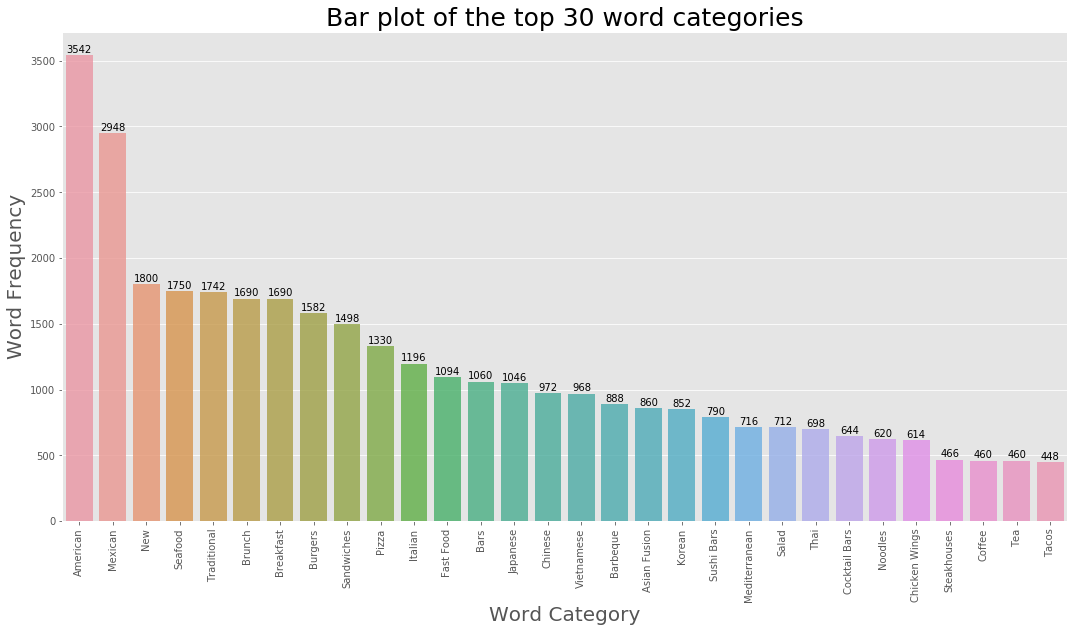

In [443]:
# Frequency Plot
catfre_df = pd.DataFrame(cat_frequency.items(), columns=['Word_Category', 'Frequency'])
# sort the df by word frequency 
catfre_df = catfre_df.sort_values('Frequency', ascending=False)
tot_cat = catfre_df.Word_Category.value_counts()
print(f"There are {len(tot_cat)} different word categories to describe restaurants in Yelp")

top_cat = catfre_df.Word_Category.iloc[0:30]
top_fre = catfre_df.Frequency.iloc[0:30]
plt.figure(figsize=(18, 9))
ax = sns.barplot(top_cat.values, top_fre.values, alpha=0.8)
plt.title("Bar plot of the top 30 word categories", fontsize=25)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.ylabel('Word Frequency', fontsize=20)
plt.xlabel('Word Category', fontsize=20)

# adding the text labels
rects = ax.patches
labels = top_fre.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

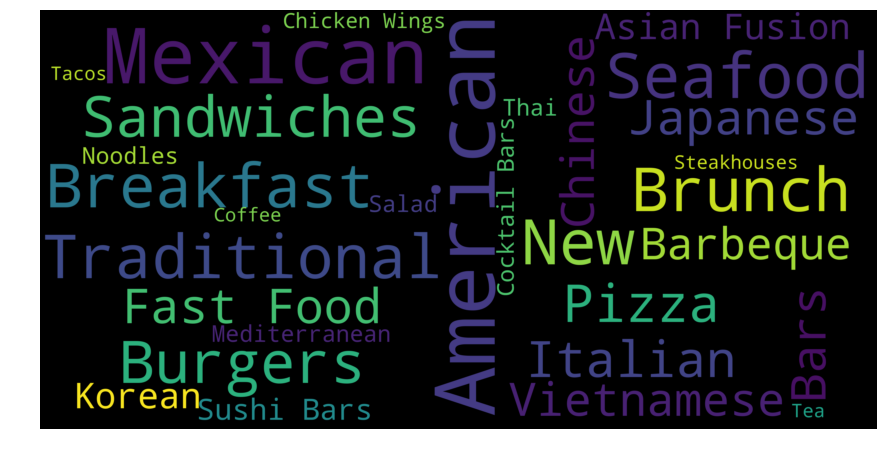

In [444]:
# word cloud plot
cats_txt_list = yelp_clean_df['Category'].to_string()
make_word_cloud(cats_txt_list, cat_frequency)

**Observations and explanation:**

### Part II: Restaurants ratings distribution analysis 

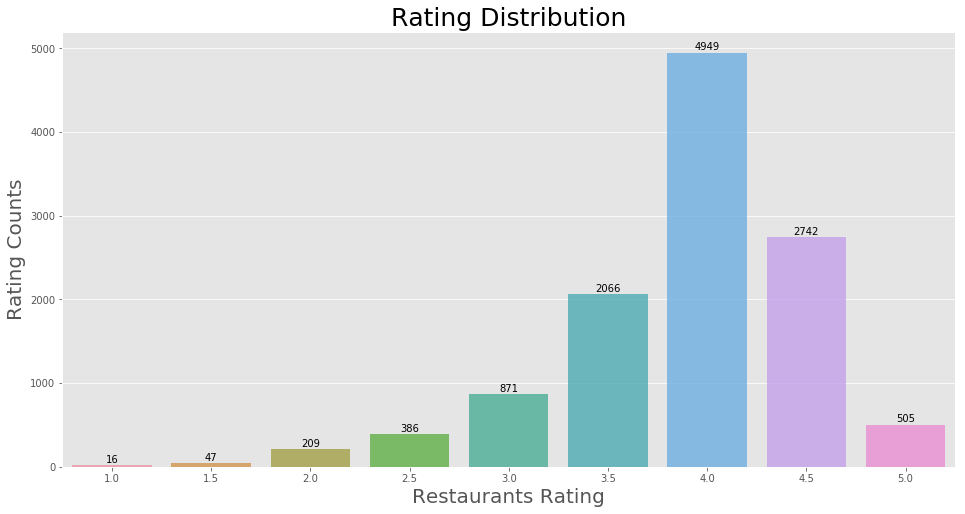

In [445]:
x_axis = yelp_clean_df['Rating'].value_counts()
x_axis.pop("Unknown")
x_axis = x_axis.sort_index()
plt.figure(figsize=(16, 8))
ax = sns.barplot(x_axis.index, x_axis.values, alpha=0.8)
plt.title("Rating Distribution", fontsize=25)
plt.xlabel("Restaurants Rating", fontsize=20)
plt.ylabel("Rating Counts", fontsize=20)

# adding the text labels
rects = ax.patches
labels = x_axis.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

### Part III: Restaurants reviews distribution analysis based on cities 

In [487]:
reviews_df = yelp_clean_df[yelp_clean_df['Reviews'] != "Unknown"]
reviews_df['Reviews'] = reviews_df['Reviews'].apply(int)

In [512]:
# sort the df by reviews frequency 
reviews_df = reviews_df.sort_values('Reviews', ascending=False)

# extract data 
v = reviews_df['Name'].values.tolist()[0:30]
d = reviews_df['Reviews'].values.tolist()[0:30]

# set up colors
color_series = ['#FAE927','#E9E416','#C9DA36','#9ECB3C','#6DBC49',
                '#37B44E','#3DBA78','#14ADCF','#209AC9','#1E91CA',
                '#2C6BA0','#2B55A1','#2D3D8E','#44388E','#6A368B',
                '#7D3990','#A63F98','#C31C88','#D52178','#D5225B',
                '#D02C2A','#D44C2D','#F57A34','#FA8F2F','#D99D21',
                '#CF7B25','#CF7B25','#CF7B25','#CF7B25','#CF7B25']

In [515]:
# pie plot instance 
pie1 = Pie(init_opts=opts.InitOpts(width='1000px', height='500px'))

# set colors
pie1.set_colors(color_series)

# import data 
pie1.add("", [list(z) for z in zip(v, d)],
        radius=["30%", "135%"],
        center=["50%", "65%"],
        rosetype="area")

# figure configurations
pie1.set_global_opts(title_opts=opts.TitleOpts(title='Top 30 restaurants with most reviews'),
                     legend_opts=opts.LegendOpts(is_show=False),
                     toolbox_opts=opts.ToolboxOpts())

pie1.set_series_opts(label_opts=opts.LabelOpts(is_show=True, position="inside", font_size=12,
                                               formatter="{b}:{c}", font_style="italic",
                                               font_weight="bold"))
pie1.render_notebook()

### Part IV: Restaurants geo-spatial analysis 

In [376]:
def get_ZIP(item):
    zip_code = item.split(',')[-1]
    if re.search(r'\d{5}', zip_code):
        return zip_code
    else:
        return "Unknown"

In [378]:
yelp_clean_df['ZIP'] = yelp_clean_df.Address.apply(get_ZIP)
yelp_clean_df['ZIP'].value_counts()["Unknown"]

12

In [380]:
yelp_clean_df.sample(3)

,Name,Address,Category,Price,Rating,Reviews,Mon,Tue,Wed,Thu,...,Delivery,Wi_Fi,Takes_Reservations,Parking,Vegetarian_Options,Accepts_Credit_Cards,Accepts_Apple_Pay,Accepts_Google_Pay,Take_out,ZIP
7005,Kokkari Estiatorio,"200 Jackson St,San Francisco,CA,94111","Greek,Mediterranean",$31-60,4.5,4516,"11:30 am - 2:30 pm,5:30 pm - 10:00 pm","11:30 am - 2:30 pm,5:30 pm - 10:00 pm","11:30 am - 2:30 pm,5:30 pm - 10:00 pm","11:30 am - 2:30 pm,5:30 pm - 10:00 pm",...,Yes,No,Yes,"Garage, Street, Private Lot",Unknown,Yes,No,Yes,No,94111
3227,Yakiniq,"1640 Post St,Fl 2,San Francisco,CA,94115","Korean,Barbeque",$11-30,3.0,1391,5:00 pm - 12:00 am,5:00 pm - 12:00 am,5:00 pm - 12:00 am,"11:00 am - 2:30 pm,5:00 pm - 12:00 am",...,No,No,Yes,Street,Unknown,Yes,No,No,No,94115
3385,El Porteño Empanadas,"1 Ferry Bldg,Ste 18,San Francisco,CA,94111","Argentine,Empanadas",Under $10,4.0,769,9:00 am - 8:00 pm,9:00 am - 8:00 pm,9:00 am - 8:00 pm,9:00 am - 8:00 pm,...,Yes,No,No,"Street, Validated",Unknown,Yes,Yes,No,Yes,94111


In [422]:
yelp_clean_df

,Name,Address,Category,Price,Rating,Reviews,Mon,Tue,Wed,Thu,...,Sun,Delivery,Wi_Fi,Takes_Reservations,Parking,Vegetarian_Options,Accepts_Credit_Cards,Accepts_Apple_Pay,Accepts_Google_Pay,Take_out
0,Dave's Hot Chicken,"3462 Wilshire Blvd,Los Angeles,CA,90010",Chicken Shop,$11-30,4.0,82,11:00 am - 1:00 am,11:00 am - 1:00 am,11:00 am - 1:00 am,11:00 am - 1:00 am,...,11:00 am - 1:00 am,No,No,No,"Garage, Street",Unknown,Yes,Yes,No,Yes
1,Chef Kang Sul Box,"3881 Wilshire Blvd,Los Angeles,CA,90010","Korean,Gastropubs,Chicken Shop",$11-30,5.0,31,5:00 pm - 2:00 am,5:00 pm - 2:00 am,5:00 pm - 2:00 am,5:00 pm - 2:00 am,...,5:00 pm - 2:00 am,Yes,Free,Yes,"Street, Private Lot, Validated",Unknown,Yes,Unknown,Unknown,Yes
2,CHD,"3377 Wilshire Blvd,Ste 104,Los Angeles,CA,90010",Korean,$11-30,4.5,26,11:00 am - 8:30 pm,11:00 am - 8:30 pm,11:00 am - 8:30 pm,11:00 am - 8:30 pm,...,Closed,No,No,No,"Valet, Validated",Yes,Yes,No,Unknown,Yes
3,Bavel,"500 Mateo St,Los Angeles,CA,90013",Middle Eastern,$31-60,4.5,1306,5:00 pm - 11:00 pm,5:00 pm - 11:00 pm,5:00 pm - 11:00 pm,5:00 pm - 11:00 pm,...,5:00 pm - 11:00 pm,No,Free,Yes,"Valet, Street",Yes,Yes,No,Unknown,Yes
4,Chinchikurin - Sawtelle,"2119 Sawtelle Blvd,Los Angeles,CA,90025",Japanese,$11-30,4.5,528,"11:30 am - 2:00 pm,5:00 pm - 10:30 pm",Closed,"11:30 am - 2:00 pm,5:00 pm - 10:30 pm","11:30 am - 2:00 pm,5:00 pm - 10:30 pm",...,"11:30 am - 2:00 pm,5:00 pm - 10:30 pm",Yes,No,Yes,"Valet, Street",Yes,Yes,No,No,Yes
5,Hae Jang Chon Korean BBQ Restaurant,"3821 W 6th St,Los Angeles,CA,90020","Korean,Barbeque",$11-30,4.0,4974,11:00 am - 2:00 am,11:00 am - 2:00 am,11:00 am - 2:00 am,11:00 am - 2:00 am,...,11:00 am - 2:00 am,No,Free,Yes,Valet,Unknown,Yes,No,No,Yes
6,Daikokuya Little Tokyo,"327 E 1st St,Los Angeles,CA,90012","Ramen,Noodles",$11-30,4.0,8494,11:00 am - 12:00 am,11:00 am - 12:00 am,11:00 am - 12:00 am,11:00 am - 12:00 am,...,11:00 am - 11:00 pm,No,No,No,Street,Yes,No,No,No,No
7,Pine & Crane,"1521 Griffith Park Blvd,Los Angeles,CA,90026","Taiwanese,Chinese,Bubble Tea",$11-30,4.5,2252,12:00 pm - 10:00 pm,Closed,12:00 pm - 10:00 pm,12:00 pm - 10:00 pm,...,12:00 pm - 10:00 pm,No,No,No,Street,Yes,Yes,Yes,No,Yes
8,Angry Chickz,"5065 Hollywood Blvd,Ste 102,Los Angeles,CA,90027","Southern,Comfort Food,Chicken Shop",$11-30,4.5,825,11:00 am - 12:00 am,11:00 am - 12:00 am,11:00 am - 12:00 am,11:00 am - 12:00 am,...,11:00 am - 12:00 am,No,Free,No,"Street, Private Lot",Unknown,Yes,Yes,Yes,Yes
9,Kang Ho-dong Baekjeong,"3465 W 6th St,Los Angeles,CA,90020","Barbeque,Korean",$11-30,4.5,4253,11:30 am - 1:30 am,11:30 am - 1:30 am,11:30 am - 1:30 am,11:30 am - 1:30 am,...,11:30 am - 1:30 am,No,No,No,Valet,Unknown,Yes,No,No,No


### Part: 

In [426]:
def make_word_cloud_park(text, max_word=30):
    """ generate word cloud by word frequency
    """
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords.words("english"),
        scale=10,
        max_words=max_word,
        max_font_size=40,
    )
    wordcloud = wordcloud.generate(text)
    plt.figure(1,figsize=(15,15))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation="bilinear") 

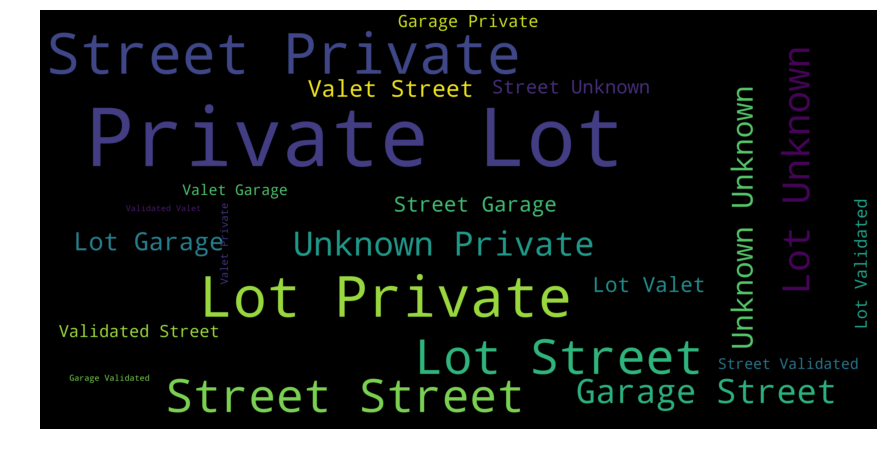

In [428]:
# parking word cloud plot
park_txt_list = yelp_clean_df['Parking'].to_string()
make_word_cloud_park(park_txt_list)